#### 라이브러리 불러오기

In [18]:
import pandas as pd
import cv2
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import PIL
import torchvision.transforms as transforms
from torchsummary import summary as summary

#### train data와 tes data 압축풀기

In [ ]:
train_data = zipfile.ZipFile("./train.zip")
train_data.extractall()

In [ ]:
test_data = zipfile.ZipFile("./test.zip")
test_data.extractall()

#### train data 불러오기 및 DataFrame 확인

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


#### Class 비율 확인

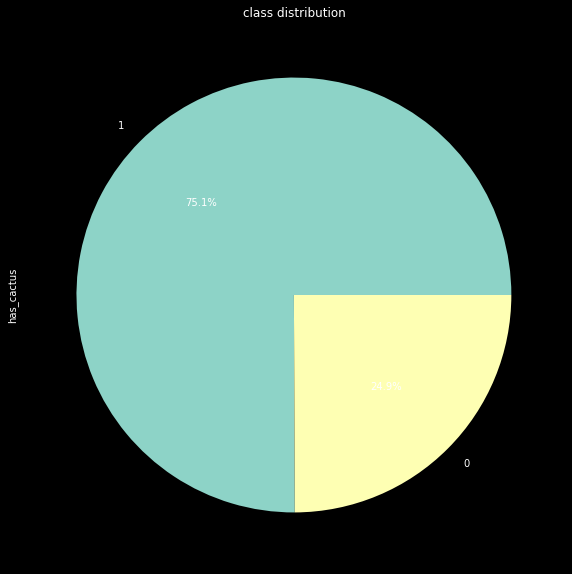

In [4]:
plt.style.use('dark_background')
plt.title("class distribution")
train['has_cactus'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(15,10))
plt.show()

#### Class 개수 확인

<AxesSubplot:xlabel='has_cactus', ylabel='count'>

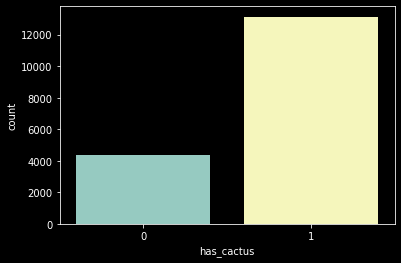

In [5]:
sns.countplot(x=train['has_cactus'])

#### train data 각 컬럼의 정보 불러오기

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17500 non-null  object
 1   has_cactus  17500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


#### 8개의 데이터 랜덤으로 추출해 이미지 확인

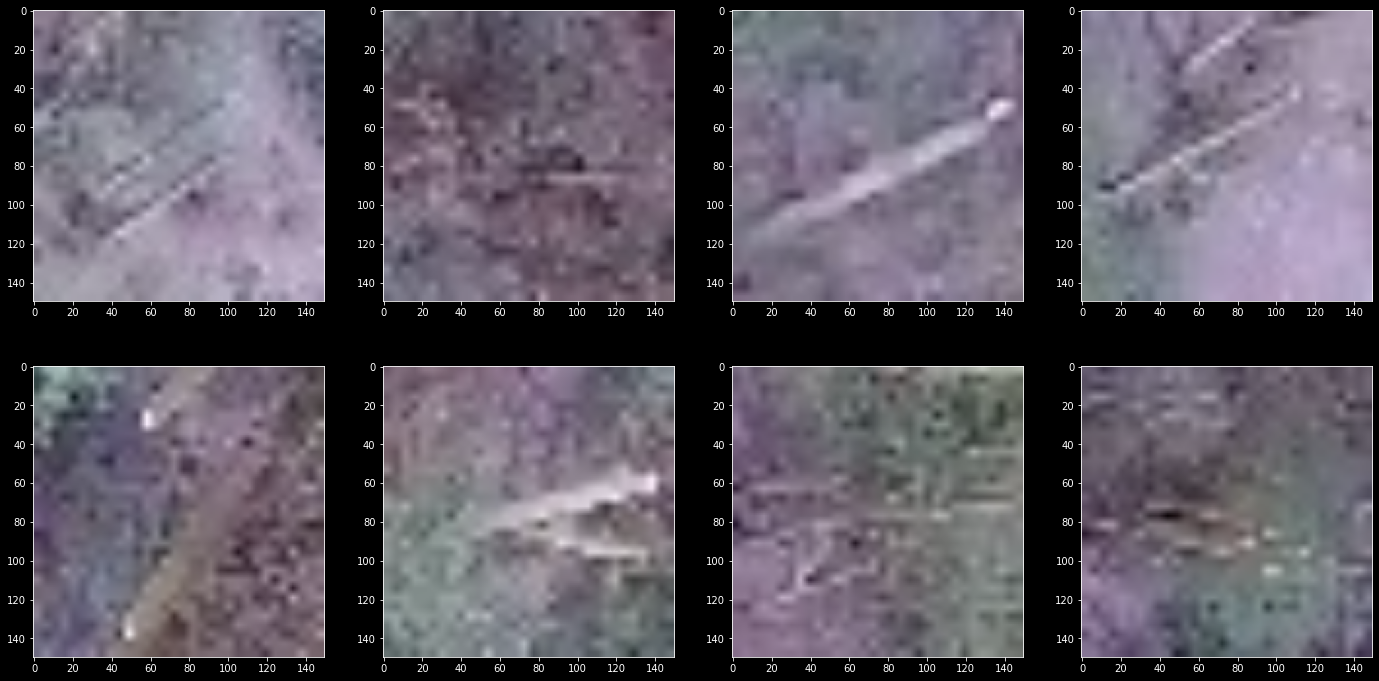

In [7]:
plt.figure(figsize=(24, 12))
for i in range(8):
    sample_id = train['id'].sample().values[0]
    sample_path = './train/'+sample_id
    sample_img = cv2.imread(sample_path)
    sample_img = cv2.resize(sample_img, dsize=(150, 150))
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_img)
plt.show()

#### torchvision transform 정의 (Data Augmentation)

In [8]:
transform = transforms.Compose([
                                    transforms.Resize(50),
                                    transforms.RandomCrop(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#### DataFrame 과 image 를 이용하여 CustomDataset 만들기

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv, images_folder, transform = None):
        self.df = csv
        self.images_folder = images_folder
        self.transform = transform
        #self.class2index = 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.iloc[index,0] 
        label = self.df.iloc[index,1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

#### Train Dataset 과 Valid Dataset으로 나누어줌

In [10]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_dataset = CustomDataset(train, "./train", transform=transform)
valid_dataset = CustomDataset(valid, "./train", transform=transform)

#### DataLoader를 이용해서 Dataset batch 단위 설정

In [12]:
from torch.utils.data import DataLoader
import torch.nn as nn

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=16, shuffle=True)

#### CNN 네트워크 구축

In [13]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, 1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.maxpool1 = nn.MaxPool2d(2,2)
        
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 16, 1)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.maxpool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)
        
        self.activ = nn.ReLU()
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activ(x)
        
        x = self.conv2(x)
        x = self.activ(x)
        
        x = self.conv3(x)
        x = self.activ(x)
        x = self.bn1(x)
        
        
        x = self.maxpool1(x)
        
        x = self.conv4(x)
        x = self.activ(x)
        
        x = self.conv5(x)
        x = self.activ(x)
        
        x = self.conv6(x)
        x = self.activ(x)
        x = self.bn2(x)

        x = self.maxpool1(x)

        #print(x.size())
        x = x.view(-1, x.size()[1]*x.size()[2]*x.size()[3])
        
        x = self.fc1(x)
        x = self.activ(x)
        
        x = self.fc2(x)
        x = self.activ(x)
        
        x = self.fc3(x)
        #x = self.activ(x)
        
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
net = Net().to(device)

print(net)

cuda:0 is available
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (activ)

#### CNN 모델 정보 불러오기

In [14]:
summary(net, (3, 32, 32))
output = net(torch.randn(16, 3, 32, 32).to(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3            [-1, 8, 32, 32]             136
              ReLU-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,168
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]             528
             ReLU-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           4,640
             ReLU-14           [-1, 32,

#### 학습시 하이퍼파라미터 설정(learning rate, epochs, Loss Function, Optimizer)

In [15]:
import torch.optim as optim

lr = 0.005
epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

#### train 함수와 evaluate 함수 정의

In [16]:
import torch.nn.functional as F

def train(model, train_dl, optimizer):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        
def eval(model, test_dl):
    
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dl):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_dl.dataset)
    test_accuracy = 100. * correct / len(test_dl.dataset)
    
    return test_loss, test_accuracy

#### Training

In [19]:
for epoch in range(1, epochs + 1):
    train(net, train_dl, optimizer)
    test_loss, test_accuracy = eval(net, valid_dl)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.1222, Accuracy: 94.66%
[2] Test Loss: 0.1003, Accuracy: 95.51%
[3] Test Loss: 0.1012, Accuracy: 95.89%
[4] Test Loss: 0.1080, Accuracy: 95.74%
[5] Test Loss: 0.0809, Accuracy: 97.14%
[6] Test Loss: 0.0709, Accuracy: 97.40%
[7] Test Loss: 0.0843, Accuracy: 96.89%
[8] Test Loss: 0.0671, Accuracy: 96.94%
[9] Test Loss: 0.0648, Accuracy: 97.80%
[10] Test Loss: 0.0519, Accuracy: 98.06%
[11] Test Loss: 0.1048, Accuracy: 97.17%
[12] Test Loss: 0.0616, Accuracy: 97.77%
[13] Test Loss: 0.0630, Accuracy: 97.63%
[14] Test Loss: 0.0863, Accuracy: 96.49%
[15] Test Loss: 0.0656, Accuracy: 97.09%
[16] Test Loss: 0.0548, Accuracy: 98.26%
[17] Test Loss: 0.0539, Accuracy: 98.00%
[18] Test Loss: 0.0620, Accuracy: 98.20%
[19] Test Loss: 0.0767, Accuracy: 97.77%
[20] Test Loss: 0.0553, Accuracy: 98.37%
[21] Test Loss: 0.0495, Accuracy: 98.46%
[22] Test Loss: 0.0829, Accuracy: 96.86%
[23] Test Loss: 0.0534, Accuracy: 98.29%
[24] Test Loss: 0.0891, Accuracy: 96.86%
[25] Test Loss: 0.0765, A

In [22]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [39]:
pred_list = []
for index, img_path in enumerate(sub_df.iloc[:,0]):

    image = PIL.Image.open(os.path.join('./test/', img_path))
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    #print(image.size())
    output = net(image)
    _, pred = torch.max(output, 1)
    pred = pred.tolist()
    print(pred[0])
    pred_list.append(pred[0])

1
1
0
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
0
0
1
1
1
1
1
0
0
1
0
1
1
1
1
1
1
0
1
1
0
1
1
1
0
1
1
1
1
0
0
1
0
0
1
1
1
0
1
1
1
0
0
0
1
1
0
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
0
1
0
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
0
0
1
0
0
0
1
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
0
0
0
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
0
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
0
1
0
0
1
1
1
1
1
0
1
0
1
1
1
0
0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
0
0
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
0
1
1
0
0
1
1
0
0
1
1
1
1
1
0
1
1
1
1
1
0


In [41]:
sub_df.iloc[:,1] = pred_list
sub_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


In [42]:
sub_df.to_csv('submit.csv')